In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LayerNormalization, Dropout, Reshape
from sklearn.preprocessing import MinMaxScaler

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/pamap2_HAR_raw.csv')

In [32]:
df=df.head(25000)

In [33]:
# Linear Interpolation and drop NANs
sensor_columns = [col for col in df.columns if col not in ['timestamp', 'activityID', 'activity_name']]
sensor_data = df[sensor_columns]
sensor_data = sensor_data.interpolate(method='linear', axis=0)
sensor_data = sensor_data.dropna()

In [34]:
# Feature Engineering
sensor_data['hand_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_hand_3D_acceleration_1']**2 +
    sensor_data['IMU_hand_3D_acceleration_2']**2 +
    sensor_data['IMU_hand_3D_acceleration_3']**2
)
sensor_data['chest_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_acceleration_1']**2 +
    sensor_data['IMU_chest_3D_acceleration_2']**2 +
    sensor_data['IMU_chest_3D_acceleration_3']**2
)
sensor_data['chest_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_gyroscope_1']**2 +
    sensor_data['IMU_chest_3D_gyroscope_2']**2 +
    sensor_data['IMU_chest_3D_gyroscope_3']**2
)
sensor_data['chest_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_magnetometer_1']**2 +
    sensor_data['IMU_chest_3D_magnetometer_2']**2 +
    sensor_data['IMU_chest_3D_magnetometer_3']**2
)
sensor_data['ankle_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_acceleration_1']**2 +
    sensor_data['IMU_ankle_3D_acceleration_2']**2 +
    sensor_data['IMU_ankle_3D_acceleration_3']**2
)
sensor_data['ankle_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_gyroscope_1']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_2']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_3']**2
)
sensor_data['ankle_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_magnetometer_1']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_2']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_3']**2
)

# Drop original columns
cols_to_drop = [
    'IMU_chest_3D_acceleration_1', 'IMU_chest_3D_acceleration_2', 'IMU_chest_3D_acceleration_3',
    'IMU_hand_3D_acceleration_1', 'IMU_hand_3D_acceleration_2', 'IMU_hand_3D_acceleration_3',
    'IMU_chest_3D_gyroscope_1', 'IMU_chest_3D_gyroscope_2', 'IMU_chest_3D_gyroscope_3',
    'IMU_hand_3D_gyroscope_1', 'IMU_hand_3D_gyroscope_2', 'IMU_hand_3D_gyroscope_3',
    'IMU_chest_3D_magnetometer_1', 'IMU_chest_3D_magnetometer_2', 'IMU_chest_3D_magnetometer_3',
    'IMU_ankle_3D_acceleration_1', 'IMU_ankle_3D_acceleration_2', 'IMU_ankle_3D_acceleration_3',
    'IMU_ankle_3D_gyroscope_1', 'IMU_ankle_3D_gyroscope_2', 'IMU_ankle_3D_gyroscope_3',
    'IMU_ankle_3D_magnetometer_1', 'IMU_ankle_3D_magnetometer_2', 'IMU_ankle_3D_magnetometer_3'
]
sensor_data = sensor_data.drop(cols_to_drop, axis=1)

In [35]:
# Min-Max Scaling
scaler = MinMaxScaler()
sensor_data_scaled = scaler.fit_transform(sensor_data)
sensor_data_scaled = pd.DataFrame(sensor_data_scaled, columns=sensor_data.columns)

In [36]:
# Reintroduce for splitting
sensor_data_scaled['timestamp'] = df['timestamp']
sensor_data_scaled['activityID'] = df['activityID']
sensor_data_scaled['activity_name'] = df['activity_name']

In [37]:
# Train-Test Split (80% train, 20% test)
train_threshold = df['timestamp'].quantile(0.8)
train_data = sensor_data_scaled[sensor_data_scaled['timestamp'] < train_threshold].drop(columns=['timestamp', 'activityID', 'activity_name'])
test_data = sensor_data_scaled[sensor_data_scaled['timestamp'] >= train_threshold].drop(columns=['timestamp', 'activityID', 'activity_name'])


In [38]:
# Create sequences for Transformer input
def create_sequences(data, seq_length=20):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i:i + seq_length].values)
    return np.array(sequences)

X_train = create_sequences(train_data)
X_test = create_sequences(test_data)

# Transformer Architecture

In [39]:
from tensorflow.keras.layers import MultiHeadAttention
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_dim, input_shape):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(input_shape[-1])
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(0.1)
        self.dropout2 = Dropout(0.1)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerAutoencoder(Model):
    def __init__(self, input_shape, num_heads=4, ff_dim=128):
        super(TransformerAutoencoder, self).__init__()
        self.encoder_layer = TransformerEncoderLayer(num_heads=num_heads, ff_dim=ff_dim, input_shape=input_shape)
        self.decoder_layer = TransformerEncoderLayer(num_heads=num_heads, ff_dim=ff_dim, input_shape=input_shape)
        self.dense = Dense(input_shape[1], activation='linear')
        self.reshape_layer = Reshape(input_shape)

    def call(self, inputs, training=None):
        encoded = self.encoder_layer(inputs, training=training)
        decoded = self.decoder_layer(encoded, training=training)
        decoded = self.dense(decoded)
        decoded = self.reshape_layer(decoded)
        return decoded

seq_length = X_train.shape[1]
num_features = X_train.shape[2]
autoencoder = TransformerAutoencoder((seq_length, num_features))
autoencoder.compile(optimizer='adam', loss='mse')

In [40]:
history=autoencoder.fit(X_train, X_train, epochs=20, batch_size=32)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - loss: 0.0535
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0015
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 8.0579e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 5.2645e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 3.7240e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 2.8604e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 2.2944e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 1.9057e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 1.6304e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 1.4386e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 1.3889e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 1.1082e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 1.0452e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step 

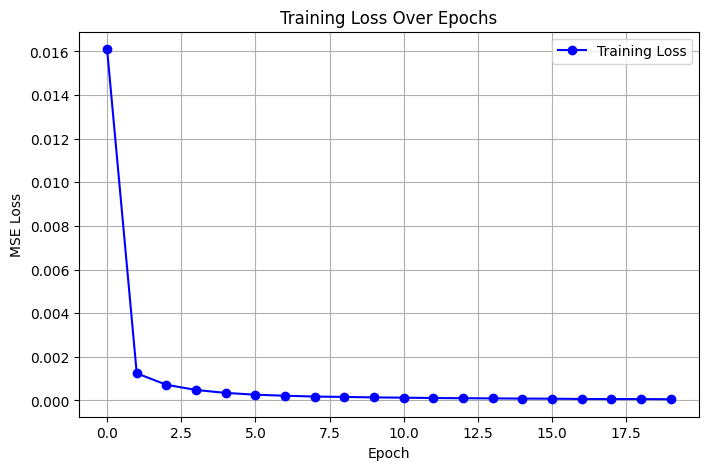

In [41]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [42]:
def compute_unsupervised_rewards(X):
    reconstructed = autoencoder.predict(X)
    reconstruction_error = np.mean(np.abs(X - reconstructed), axis=2)
    threshold = np.percentile(reconstruction_error, 95, axis=0, keepdims=True)
    rewards = (reconstruction_error > threshold).astype(int)
    return rewards

unsupervised_rewards = compute_unsupervised_rewards(X_train)
unsupervised_rewards = np.expand_dims(unsupervised_rewards, axis=-1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step


In [44]:
# Compute threshold
threshold = np.percentile(reconstruction_error, 95, axis=0, keepdims=True)

# Identify anomalous rewards
rewards = (reconstruction_error > threshold).astype(int)
anomalous_points = np.where(rewards.flatten() == 1)[0]

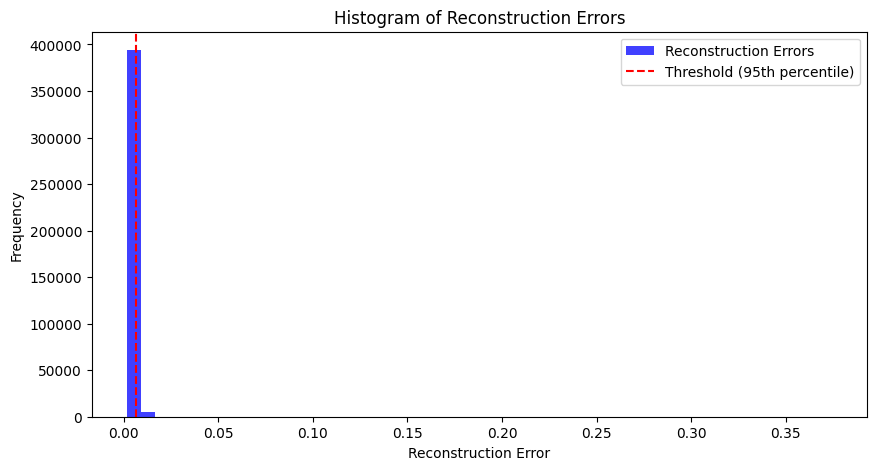

In [45]:
plt.figure(figsize=(10,5))
plt.hist(reconstruction_error.flatten(), bins=50, alpha=0.75, color='blue', label="Reconstruction Errors")
plt.axvline(x=threshold.flatten()[0], color='r', linestyle='--', label="Threshold (95th percentile)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Histogram of Reconstruction Errors")
plt.legend()
plt.show()


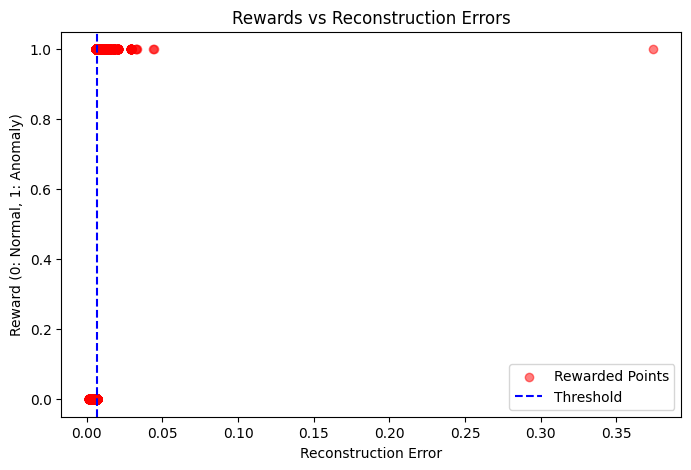

In [46]:
plt.figure(figsize=(8,5))
plt.scatter(reconstruction_error.flatten(), rewards.flatten(), c='red', alpha=0.5, label="Rewarded Points")
plt.axvline(x=threshold.flatten()[0], color='b', linestyle='--', label="Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Reward (0: Normal, 1: Anomaly)")
plt.title("Rewards vs Reconstruction Errors")
plt.legend()
plt.show()


# PPO Agent

In [47]:
class PPOAgent(tf.keras.Model):
    def __init__(self, num_actions):
        super(PPOAgent, self).__init__()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(64, activation='relu')
        self.policy_logits = Dense(num_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.policy_logits(x)

num_actions = 2
ppo_model = PPOAgent(num_actions)

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

policy_losses = []
policy_entropies = []

class PPOTrainer:
    def __init__(self, model, gamma=0.99, learning_rate=0.0001):
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.gamma = gamma

    def train(self, X, rewards, epochs=10):
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                logits = self.model(X)
                policy_out = tf.nn.softmax(logits)

                # One-hot encoding for actions
                rewards_binary = np.where(rewards > 0, 1, 0).astype(int)
                rewards_binary = rewards_binary.reshape(rewards_binary.shape[0], rewards_binary.shape[1])

                action_probs = tf.reduce_sum(policy_out * tf.one_hot(rewards_binary, depth=2), axis=-1)

                # PPO Loss (negative log likelihood)
                loss = -tf.reduce_mean(tf.math.log(action_probs + 1e-10) * tf.cast(rewards_binary, tf.float32))

                # Policy Entropy (measure of exploration)
                entropy = -tf.reduce_mean(tf.reduce_sum(policy_out * tf.math.log(policy_out + 1e-10), axis=-1))

            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

            policy_losses.append(loss.numpy())
            policy_entropies.append(entropy.numpy())

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}, Entropy: {entropy.numpy():.4f}")

In [49]:
# Train PPO
ppo_trainer = PPOTrainer(ppo_model)
ppo_trainer.train(X_train, unsupervised_rewards, epochs=10)

Epoch 1/10, Loss: 0.0418, Entropy: 0.6844
Epoch 2/10, Loss: 0.0413, Entropy: 0.6854
Epoch 3/10, Loss: 0.0409, Entropy: 0.6863
Epoch 4/10, Loss: 0.0404, Entropy: 0.6872
Epoch 5/10, Loss: 0.0400, Entropy: 0.6880
Epoch 6/10, Loss: 0.0396, Entropy: 0.6888
Epoch 7/10, Loss: 0.0391, Entropy: 0.6895
Epoch 8/10, Loss: 0.0387, Entropy: 0.6901
Epoch 9/10, Loss: 0.0383, Entropy: 0.6906
Epoch 10/10, Loss: 0.0379, Entropy: 0.6911


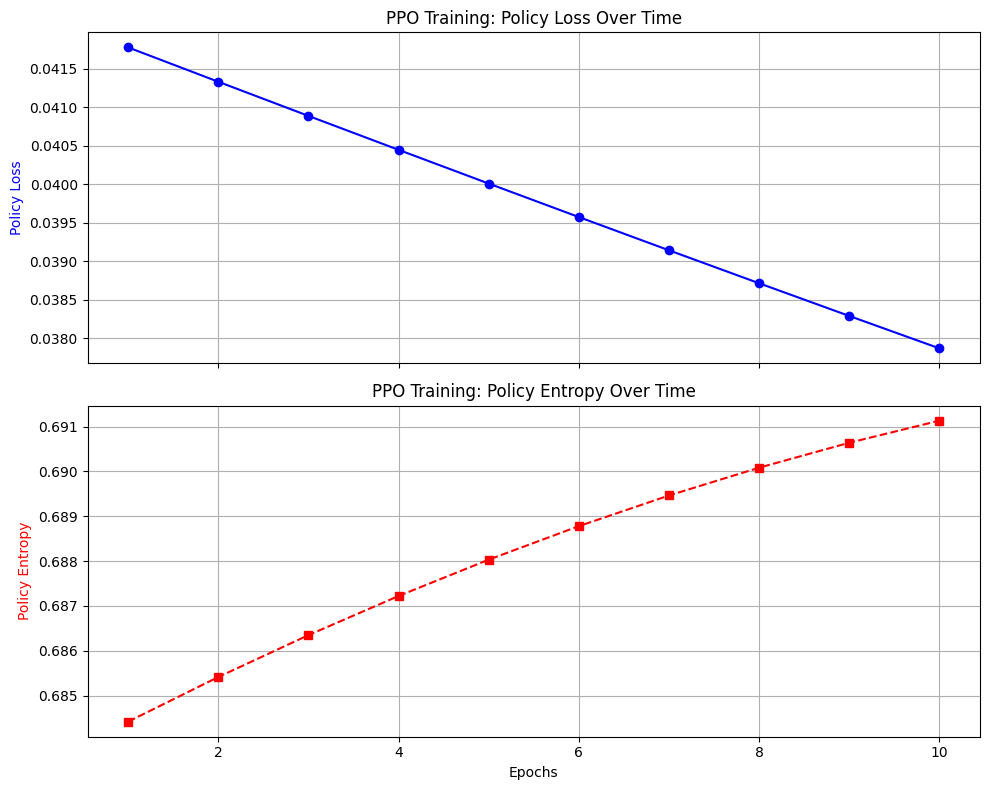

In [50]:
# Create two separate subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Plot Policy Loss
axes[0].plot(range(1, len(policy_losses) + 1), policy_losses, marker='o', linestyle='-', color='blue')
axes[0].set_ylabel("Policy Loss", color='blue')
axes[0].set_title("PPO Training: Policy Loss Over Time")
axes[0].grid(True)

# Plot Policy Entropy
axes[1].plot(range(1, len(policy_entropies) + 1), policy_entropies, marker='s', linestyle='--', color='red')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Policy Entropy", color='red')
axes[1].set_title("PPO Training: Policy Entropy Over Time")
axes[1].grid(True)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


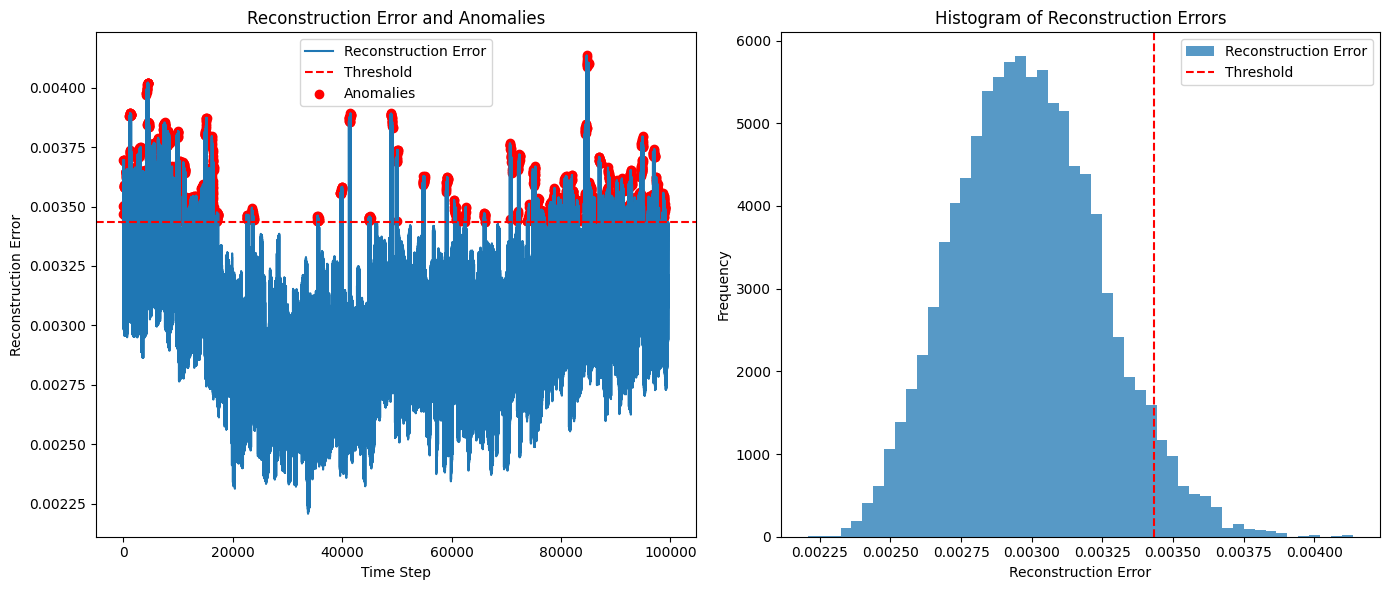

Total number of anomalies detected: 4980
Indices of anomalous points: [    3     6    12 ... 99022 99041 99060]
Reconstruction errors of anomalous points: [0.00346806 0.00369579 0.00350357 ... 0.00349164 0.00348882 0.00348211]


In [51]:
reconstructed_test = autoencoder.predict(X_test)
reconstruction_error_test = np.mean(np.abs(X_test - reconstructed_test), axis=2)

threshold = np.percentile(reconstruction_error_test, 95, axis=0, keepdims=True)

anomalies = (reconstruction_error_test > threshold).astype(int)
total_anomalies = np.sum(anomalies)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(reconstruction_error_test.flatten(), label='Reconstruction Error')
plt.axhline(y=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies.flatten() == 1), reconstruction_error_test.flatten()[anomalies.flatten() == 1], color='r', label='Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error and Anomalies')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(reconstruction_error_test.flatten(), bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(x=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total number of anomalies detected: {total_anomalies}")

anomalous_points = np.where(anomalies.flatten() == 1)[0]
print("Indices of anomalous points:", anomalous_points)
print("Reconstruction errors of anomalous points:", reconstruction_error_test.flatten()[anomalous_points])

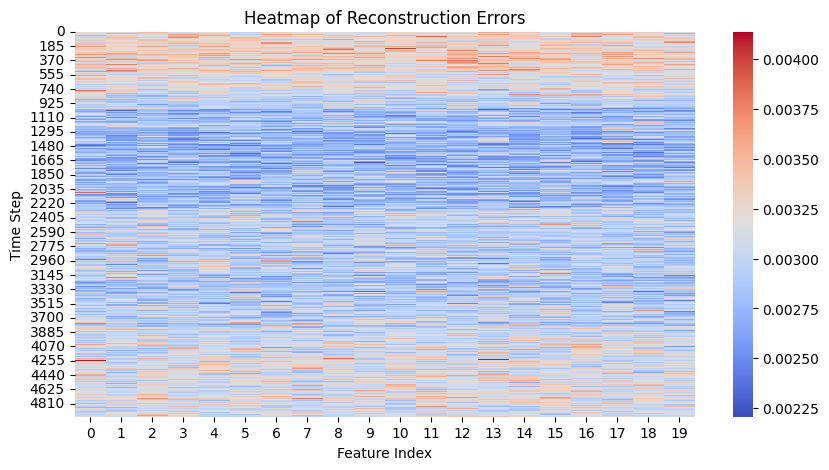

In [52]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(reconstruction_error_test, cmap="coolwarm", annot=False, cbar=True)
plt.xlabel("Feature Index")
plt.ylabel("Time Step")
plt.title("Heatmap of Reconstruction Errors")
plt.show()


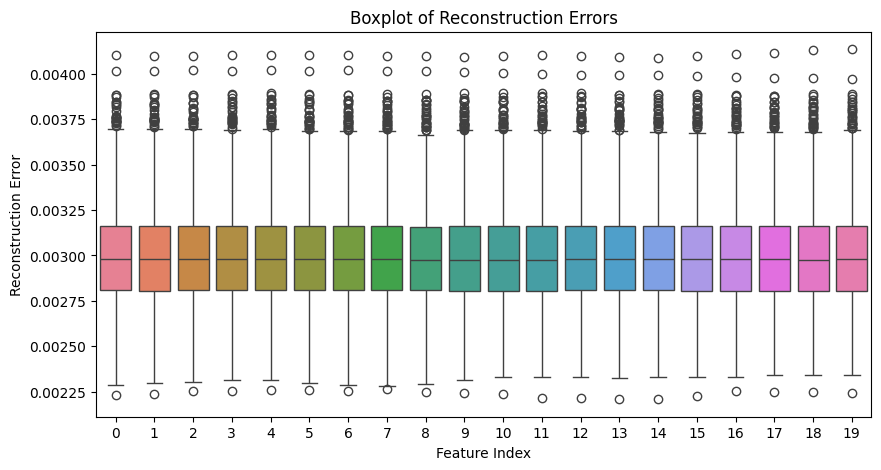

In [53]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=reconstruction_error_test)
plt.xlabel("Feature Index")
plt.ylabel("Reconstruction Error")
plt.title("Boxplot of Reconstruction Errors")
plt.show()


<ipython-input-54-3a1f2f252419>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(reconstruction_error_test.flatten(), shade=True, label="Reconstruction Error Density", color='blue')


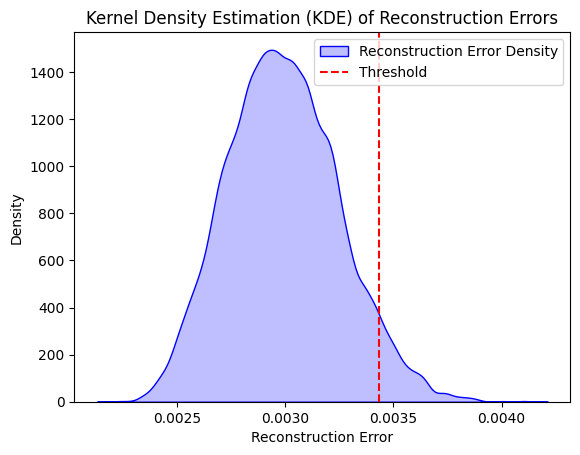

In [54]:
sns.kdeplot(reconstruction_error_test.flatten(), shade=True, label="Reconstruction Error Density", color='blue')
plt.axvline(x=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Kernel Density Estimation (KDE) of Reconstruction Errors")
plt.legend()
plt.show()
